In [154]:

import os, math, random, time
import numpy as np
import pandas as pd
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
import joblib

In [155]:
df = pd.read_csv("data/data_train_sentinel_landsat.csv")
df

,X_Centroid_S,Y_Centroid_S,SOC_10,Stock_C,Profondeur(cm),Depth,Num_Parc_1,Type_sol,Sand,Predicted_FF,...,SR_B4,SR_B5,SR_B6,SR_B7,LNDVI,LNDWI,LBSI,Lcigreen,X_Centroid_L,Y_Centroid_L
0,337666.904000,1.613466e+06,6.04,11.08,10,NaN,685.0,3,88.1,6.8,...,14679.331688,19777.197433,24596.239882,21141.454097,0.147951,-0.108602,0.132685,0.094934,337666.904000,1.613466e+06
1,337665.277100,1.613491e+06,6.04,19.28,10,NaN,345.0,3,85.3,7.4,...,14612.936821,19286.111550,24284.315893,21180.730503,0.137856,-0.114716,0.135156,0.093342,337665.277100,1.613491e+06
2,337901.175800,1.613567e+06,3.67,5.62,10,NaN,25.0,2,91.5,3.2,...,16600.637081,21326.907298,28143.011834,25794.826430,0.124613,-0.137783,0.156696,0.100950,337901.175800,1.613567e+06
3,337918.069200,1.613497e+06,5.05,7.88,10,NaN,648.0,2,90.2,4.2,...,16227.502463,21110.740887,27282.456158,24554.470936,0.130784,-0.127533,0.149166,0.098049,337918.069200,1.613497e+06
4,337909.127500,1.613461e+06,6.04,10.28,10,NaN,675.0,2,88.8,6.0,...,15320.353406,20030.712734,25631.906219,23030.277394,0.133245,-0.122665,0.139686,0.089887,337909.127500,1.613461e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,337684.567791,1.602395e+06,3.82,5.92,10,NaN,53.0,3,88.5,4.8,...,16552.448174,21299.229023,27955.166831,24787.390918,0.125405,-0.135134,0.154409,0.099206,337684.567791,1.602395e+06
1795,336242.852572,1.602357e+06,3.48,5.47,10,NaN,54.0,3,89.2,4.6,...,18055.559289,22716.131423,29336.993083,26473.951581,0.114309,-0.127194,0.154744,0.110380,336242.852572,1.602357e+06
1796,336184.773989,1.602435e+06,3.50,5.49,10,NaN,55.0,3,89.2,4.7,...,18124.431953,22709.339250,29384.819527,26545.734714,0.112282,-0.128143,0.154504,0.105949,336184.773989,1.602435e+06
1797,336295.437751,1.602552e+06,2.27,3.57,10,NaN,56.0,3,91.1,2.5,...,17943.737931,22896.266995,28867.213793,25181.205911,0.121267,-0.115351,0.146552,0.105203,336295.437751,1.602552e+06


In [156]:
df.columns

Index(['X_Centroid_S', 'Y_Centroid_S', 'SOC_10', 'Stock_C', 'Profondeur(cm)',
       'Depth', 'Num_Parc_1', 'Type_sol', 'Sand', 'Predicted_FF', 'FF_0-30',
       'Type_champ', 'Site', 'Epaisseur_(cm)', 'Superficie', 'Da', 'Parcage',
       'Couverture_sol', 'Antecedent_cultural', 'Termitere', 'Date', 'Saison',
       'profile_id', 'Longitude_x', 'Latitude_x', 'Longitude_Latitude',
       'ProfileID', 'Longitude_y', 'Latitude_y', 'T_Year', 'Start_Date',
       'End_Date', 'Satellite', 'error', 'VV', 'VH', 'B1', 'B2', 'B3', 'B4',
       'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'SNDVI',
       'SGDVI', 'SMSAVI2', 'SPSRINIR', 'SNDWI', 'Scigreen', 'SOC_30', 'SR_B1',
       'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'LNDVI', 'LNDWI',
       'LBSI', 'Lcigreen', 'X_Centroid_L', 'Y_Centroid_L'],
      dtype='object')

In [157]:
# configuration du device
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)


Device: mps


In [158]:

# Configurations des features et cibles

LANDSAT_BANDS = [f"SR_B{i}" for i in range(1, 8)]  # SR_B2..SR_B7
SENTINEL_BANDS = [] #[f"B{i}" for i in range(1, 13)]  # SR_B1..SR_B12
# REMOVE B10
# SENTINEL_BANDS.remove("B10")
INDICES = []
# INDICES    = ['SNDVI','SGDVI', 'SMSAVI2', 'SPSRINIR', 'SNDWI', 'Scigreen',  'LNDVI', 'LNDWI','LBSI', 'Lcigreen',]
# [ ,'B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12','SNDVI','SGDVI','SMSAVI2','SPSRINIR','SNDWI','Scigreen',]
# OTHER =  ['Type_sol', 'Sand', 'Type_champ', 'Site', 'Superficie', 'Couverture_sol', 'Antecedent_cultural']
# OTHER =  ["Site", 'Sand','Couverture_sol','Antecedent_cultural','Type_sol','Type_champ']
OTHER =  []
FEATURES   = [c for c in (LANDSAT_BANDS + SENTINEL_BANDS + INDICES + OTHER) if c in df.columns]  # adapte si besoin

TARGET_10  = "SOC_10"
TARGET_30  = "SOC_30"
GROUP_COL  = "Site"
ID_COL     = "ProfileID"

In [159]:
FEATURES

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

In [160]:
# -----------------------
# Dataset et modèle
# -----------------------
class TabDataset(Dataset):
    """Dataset PyTorch pour les données tabulaires."""
    def __init__(self, X, y=None, sample_weight=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
        self.w = None if sample_weight is None else torch.tensor(sample_weight, dtype=torch.float32).reshape(-1, 1)

    def __len__(self): return self.X.size(0)
    def __getitem__(self, idx):
        if self.y is None: 
            return self.X[idx]
        out = (self.X[idx], self.y[idx])
        if self.w is not None: out += (self.w[idx],)
        return out

class MLP(nn.Module):
    """Réseau de neurones feedforward simple."""
    def __init__(self, in_dim, hidden=[128, 128], dropout=0.2):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.GELU(), nn.BatchNorm1d(h), nn.Dropout(dropout)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [161]:
# definition de la fonction de perte avec pondération optionnelle
def mse_loss(pred, target, weight=None):
    if weight is None:
        return nn.functional.mse_loss(pred, target)
    return torch.mean(weight * (pred - target) ** 2)

In [162]:
# definition d'un tracker de pertes et fonction de plot
from dataclasses import dataclass

@dataclass
class LossTracker:
    train: list
    val: list
    def __init__(self):
        self.train = []
        self.val = []

def plot_losses(tracker, title="Training / Validation Loss"):
    import matplotlib.pyplot as plt
    plt.figure()
    if getattr(tracker, "train", None):
        plt.plot(tracker.train, label="train")
    if getattr(tracker, "val", None):
        plt.plot(tracker.val, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()



In [163]:
# definition d'une boucle d'entrainement avec early stopping
@dataclass
class TrainCfg:
    # Configuration des hyperparamètres d'entraînement
    epochs: int = 500
    batch_size: int = 128
    lr: float = 1e-3
    weight_decay: float = 1e-3
    patience: int = 40

def train_one_fold(X_tr, y_tr, X_va, y_va, sample_w_tr=None, sample_w_va=None,
                   hidden=[256, 128], dropout=0.25, cfg=TrainCfg()):
    # Entraîne un modèle MLP sur un pli de données avec early stopping.
    model = MLP(X_tr.shape[1], hidden=hidden, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10, )

    ds_tr = TabDataset(X_tr, y_tr, sample_w_tr)
    ds_va = TabDataset(X_va, y_va, sample_w_va)
    dl_tr = DataLoader(ds_tr, batch_size=cfg.batch_size, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=512, shuffle=False)

    best_state, best_loss, no_improve = None, float("inf"), 0

    
    
  

    for epoch in range(cfg.epochs):
        model.train()
        train_loss = 0.0
        for batch in dl_tr:
            if len(batch) == 3:
                xb, yb, wb = [t.to(device) for t in batch]
            else:
                xb, yb = [t.to(device) for t in batch]
                wb = None
            opt.zero_grad()
            pred = model(xb)
            loss = mse_loss(pred, yb, wb)
            loss.backward()
            opt.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(ds_tr)

        # val
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in dl_va:
                if len(batch) == 3:
                    xb, yb, wb = [t.to(device) for t in batch]
                else:
                    xb, yb = [t.to(device) for t in batch]
                    wb = None
                pred = model(xb)
                val_loss += mse_loss(pred, yb, wb).item() * xb.size(0)
        val_loss /= len(ds_va)
        if math.isnan(val_loss):
            print(f"NaN validation loss at epoch {epoch}. Using current model.")
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            break
        scheduler.step(val_loss)

        # toujours sauvegarder le modèle de la première époque
        if epoch == 0:
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_loss = val_loss
        elif val_loss < best_loss - 1e-6:
            best_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= cfg.patience:
                break

    # si jamais pas d'amélioration, on utilise le modèle de la dernière époque
    if best_state is None:
        best_state = model.state_dict()
        print("Warning: Using final epoch model as no improvement was recorded.")

    model.load_state_dict(best_state)
    # retourne predictions sur le set de validation
    model.eval()
    with torch.no_grad():
        yhat_va = model(torch.tensor(X_va, dtype=torch.float32, device=device)).cpu().numpy().ravel()
    return model, yhat_va, best_loss

In [164]:
# -----------------------
# Train/Eval loop with early stopping
# -----------------------
@dataclass
class TrainCfg:
    epochs: int = 500
    batch_size: int = 128
    lr: float = 1e-3
    weight_decay: float = 1e-3
    patience: int = 40

def train_one_fold(X_tr, y_tr, X_va, y_va, sample_w_tr=None, sample_w_va=None,
                   hidden=[256, 128], dropout=0.25, cfg=TrainCfg(), tracker=None):
    model = MLP(X_tr.shape[1], hidden=hidden, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10, )

    ds_tr = TabDataset(X_tr, y_tr, sample_w_tr)
    ds_va = TabDataset(X_va, y_va, sample_w_va)
    dl_tr = DataLoader(ds_tr, batch_size=cfg.batch_size, shuffle=True)
    dl_va = DataLoader(ds_va, batch_size=512, shuffle=False)

    best_state, best_loss, no_improve = None, float("inf"), 0

    
    
  

    for epoch in range(cfg.epochs):
        model.train()
        train_loss = 0.0
        for batch in dl_tr:
            if len(batch) == 3:
                xb, yb, wb = [t.to(device) for t in batch]
            else:
                xb, yb = [t.to(device) for t in batch]
                wb = None
            opt.zero_grad()
            pred = model(xb)
            loss = mse_loss(pred, yb, wb)
            loss.backward()
            opt.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(ds_tr)

        # log train loss
        if tracker is not None:
            tracker.train.append(float(train_loss))

        # val
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in dl_va:
                if len(batch) == 3:
                    xb, yb, wb = [t.to(device) for t in batch]
                else:
                    xb, yb = [t.to(device) for t in batch]
                    wb = None
                pred = model(xb)
                val_loss += mse_loss(pred, yb, wb).item() * xb.size(0)
        val_loss /= len(ds_va)
        # log val loss
        if tracker is not None:
            tracker.val.append(float(val_loss))
        if math.isnan(val_loss):
            print(f"NaN validation loss at epoch {epoch}. Using current model.")
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            break
        scheduler.step(val_loss)

        # Always save the first epoch's model
        if epoch == 0:
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_loss = val_loss
        elif val_loss < best_loss - 1e-6:
            best_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= cfg.patience:
                break

    # Ensure best_state is never None
    if best_state is None:
        best_state = model.state_dict()
        print("Warning: Using final epoch model as no improvement was recorded.")

    model.load_state_dict(best_state)
    # return preds on validation set
    model.eval()
    with torch.no_grad():
        yhat_va = model(torch.tensor(X_va, dtype=torch.float32, device=device)).cpu().numpy().ravel()
    return model, yhat_va, best_loss

In [165]:
# definition d'un transformeur de cible
class Log1pTransformer:
    # Transforme la cible avec log1p
    def fit(self, y): return self
    def transform(self, y): return np.log1p(y)
    def inverse_transform(self, y): return np.expm1(y)

class YeoJohnsonTransformer:
    # Transforme la cible avec Yeo-Johnson
    def __init__(self): self.pt = PowerTransformer(method="yeo-johnson", standardize=True)
    def fit(self, y): self.pt.fit(y.reshape(-1,1)); return self
    def transform(self, y): return self.pt.transform(y.reshape(-1,1)).ravel()
    def inverse_transform(self, y): return self.pt.inverse_transform(y.reshape(-1,1)).ravel()

In [166]:
# fonctions pour évaluer les performances par site et calculer des poids d'échantillonnage
def per_site_metrics(y_true, y_pred, sites):
    dfm = pd.DataFrame({"Site": sites, "y": y_true, "yhat": y_pred})
    rows = []
    for s, d in dfm.groupby("Site"):
        r2 = r2_score(d["y"], d["yhat"]) if d["y"].nunique() > 1 else np.nan
        rmse = np.sqrt(mean_squared_error(d["y"], d["yhat"], ))
        rows.append({"Site": s, "R2": r2, "RMSE": rmse, "n": len(d)})
    return pd.DataFrame(rows).sort_values("R2", ascending=False)

def site_sample_weights(sites):
    counts = pd.Series(sites).value_counts()
    w = 1.0 / counts
    return pd.Series(sites).map(w).values

In [167]:
# boucle d'entrainement avec KFold par site
def fit_oof_nn(df_in, features, target, group_col="Site", transform="log1p",
               hidden=[256,128], dropout=0.25, train_cfg=TrainCfg(), n_splits=3):
    df_work = df_in.dropna(subset=[target]).copy()
    X_all = df_work[features].values
    y_all = df_work[target].values.astype(float)
    groups = df_work[group_col].values

    # transformation de la cible
    if transform == "log1p":
        tt = Log1pTransformer().fit(y_all)
    else:
        tt = YeoJohnsonTransformer().fit(y_all)
    y_all_t = tt.transform(y_all)

    # Boucle OOF ( out-of-fold )
    oof_pred_t = np.zeros_like(y_all_t)  
    models, scalers, imputers = [], [], []

    gkf = GroupKFold(n_splits=n_splits)
    for fold, (tr, va) in enumerate(gkf.split(X_all, y_all_t, groups)):
        X_tr_raw, X_va_raw = X_all[tr], X_all[va]
        y_tr_t, y_va_t     = y_all_t[tr], y_all_t[va]
        g_tr, g_va         = groups[tr], groups[va]

        # Imputation + Scaling
        imp = SimpleImputer(strategy="median").fit(X_tr_raw)
        X_tr_imp = imp.transform(X_tr_raw)
        X_va_imp = imp.transform(X_va_raw)

        sc = StandardScaler().fit(X_tr_imp)
        X_tr = sc.transform(X_tr_imp)
        X_va = sc.transform(X_va_imp)

        # site balancing 
        w_tr = site_sample_weights(g_tr)
        w_va = site_sample_weights(g_va)
        tracker = LossTracker()
        model, yhat_va_t, best_loss = train_one_fold(
            X_tr, y_tr_t, X_va, y_va_t,
            sample_w_tr=w_tr, sample_w_va=w_va,
            hidden=hidden, dropout=dropout, cfg=train_cfg,
            tracker=tracker,               # <= NEW
        )
        plot_losses(tracker, title="Fold 0 — Loss")
        oof_pred_t[va] = yhat_va_t
        models.append(model); scalers.append(sc); imputers.append(imp)
        print(f"[{target}] Fold {fold+1}/{n_splits} - best val loss (transformed): {best_loss:.4f}")

    # trnsformation inverse des prédictions OOF pour obtenir les valeurs dans l'espace original
    oof_pred = tt.inverse_transform(oof_pred_t)

    # metrics
    r2  = r2_score(y_all, oof_pred)
    rmse = np.sqrt(mean_squared_error(y_all, oof_pred))
    print(f"OOF {target} -> R2: {r2:.3f} | RMSE: {rmse:.3f}")

    # metrics par site
    metrics = per_site_metrics(y_all, oof_pred, groups)
    print(f"\n=== Metrics {target} par Site ===")
    print(metrics)

    # sauvegarde de l'artifact 
    artifact = {
        "models": models, "scalers": scalers, "imputers": imputers,
        "transformer": tt, "features": features, "target": target,
        "group_col": group_col
    }
    return df_work[[ID_COL, group_col, target]].assign(oof=oof_pred), artifact

In [168]:
# fonction de prédiction avec l'ensemble de modèles entrainés
def predict_nn_ensemble(artifact, df_new):
    X = df_new[artifact["features"]].values
    print(artifact["features"])
    preds_t = []
    for imp, sc, model in zip(artifact["imputers"], artifact["scalers"], artifact["models"]):
        Xp = sc.transform(imp.transform(X))
        with torch.no_grad():
            pred_t = model(torch.tensor(Xp, dtype=torch.float32, device=device)).cpu().numpy().ravel()
        preds_t.append(pred_t)
    pred_t_mean = np.mean(np.stack(preds_t, axis=0), axis=0)
    return artifact["transformer"].inverse_transform(pred_t_mean)

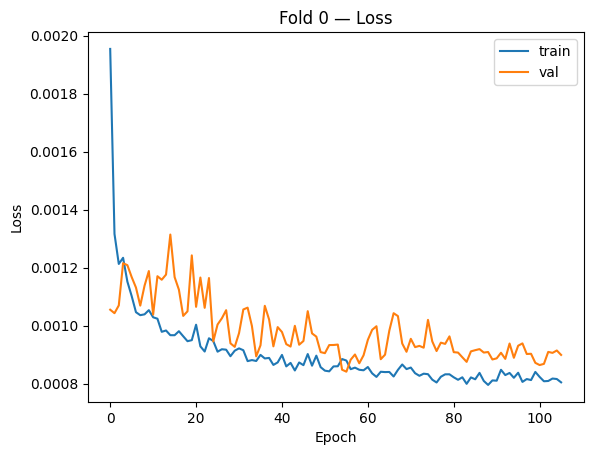

[SOC_10] Fold 1/3 - best val loss (transformed): 0.0008


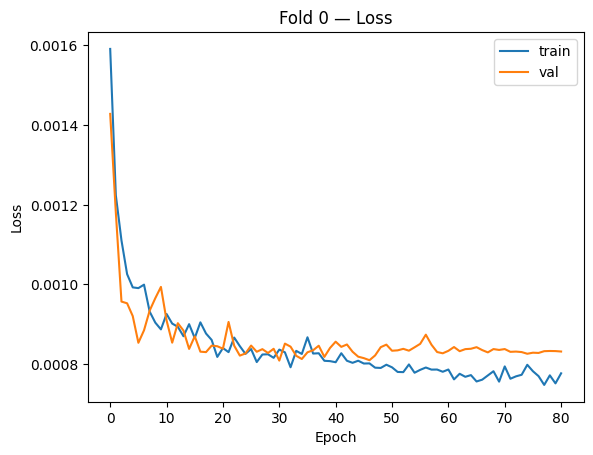

[SOC_10] Fold 2/3 - best val loss (transformed): 0.0008


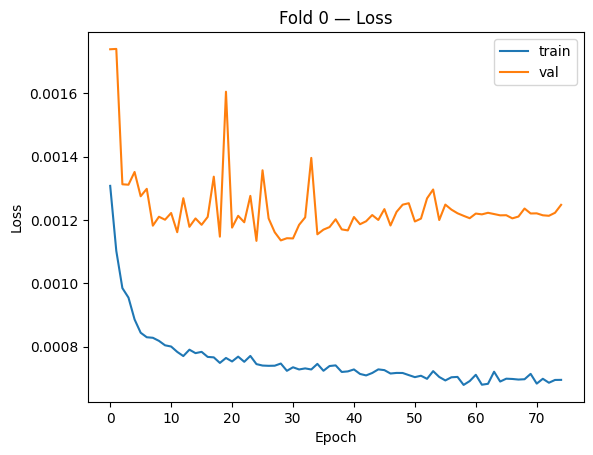

[SOC_10] Fold 3/3 - best val loss (transformed): 0.0011
OOF SOC_10 -> R2: 0.462 | RMSE: 0.866

=== Metrics SOC_10 par Site ===
   Site        R2      RMSE    n
1     1  0.570370  0.779435  418
0     0  0.439179  0.877738  619
2     2  0.342627  0.900049  762


In [169]:
# Entraînement du modèle pour SOC_10 
oof10_df, art10 = fit_oof_nn(
    df, FEATURES, TARGET_10,
    group_col=GROUP_COL,
    transform="yeo-johnson",           
    hidden=[256, 128, 64],             
    dropout=0.25,
    train_cfg=TrainCfg(
        epochs=600, batch_size=128, lr=2e-3, weight_decay=5e-4, patience=50
    ),
    n_splits=3)


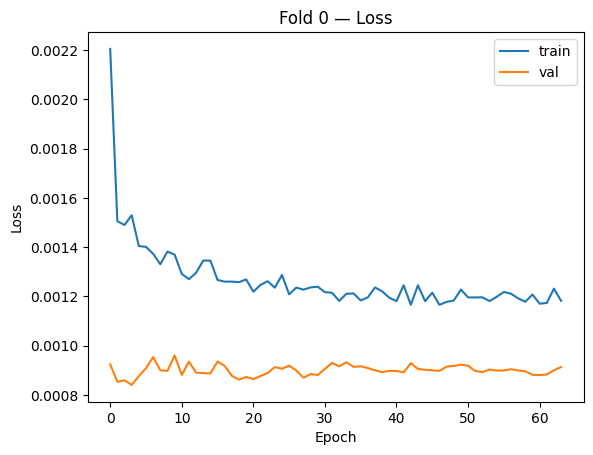

[SOC_30] Fold 1/3 - best val loss (transformed): 0.0008


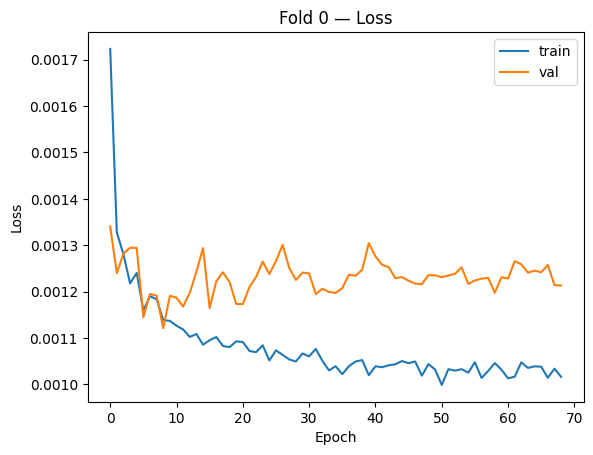

[SOC_30] Fold 2/3 - best val loss (transformed): 0.0011


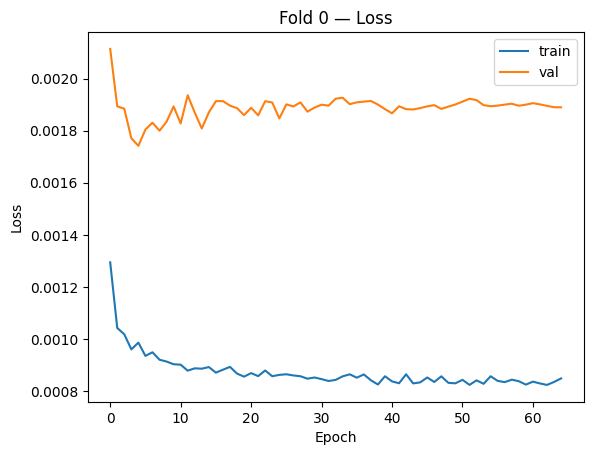

[SOC_30] Fold 3/3 - best val loss (transformed): 0.0017
OOF SOC_30 -> R2: 0.345 | RMSE: 0.900

=== Metrics SOC_30 par Site ===
   Site        R2      RMSE    n
1     1  0.437716  0.828720  415
2     2  0.262699  0.833362  762
0     0  0.259036  1.018503  619


In [170]:
# Entraînement du modèle pour SOC_30 en utilisant SOC_10_oof comme feature supplémentaire
df_30 = df.merge(oof10_df[[ID_COL, "oof"]].rename(columns={"oof": "SOC10_oof"}),
                 on=ID_COL, how="left")

FEATURES_30 = FEATURES + ["SOC10_oof"]
FEATURES_30 = [c for c in FEATURES_30 if c in df_30.columns]

oof30_df, art30 = fit_oof_nn(
    df_30, FEATURES_30, TARGET_30,
    group_col=GROUP_COL,
    transform="yeo-johnson",
    hidden=[256, 128, 64],
    dropout=0.25,
    train_cfg=TrainCfg(
        epochs=700, batch_size=128, lr=2e-3, weight_decay=8e-4, patience=60
    ),
    n_splits=3
)

In [171]:
data_train_landsat = pd.read_csv("data/lansat_zones_villages_results_landsat_30.csv")

data_train_landsat["LNDVI"] = (data_train_landsat["SR_B5"] - data_train_landsat["SR_B4"]) / (data_train_landsat["SR_B5"] + data_train_landsat["SR_B4"])
data_train_landsat["LNDWI"] = (data_train_landsat["SR_B5"] - data_train_landsat["SR_B6"]) / (data_train_landsat["SR_B5"] + data_train_landsat["SR_B6"])
data_train_landsat["LBSI"] = ((data_train_landsat["SR_B6"] + data_train_landsat["SR_B4"]) - (data_train_landsat["SR_B5"] + data_train_landsat["SR_B2"])) / ((data_train_landsat["SR_B6"] + data_train_landsat["SR_B4"]) + (data_train_landsat["SR_B5"] + data_train_landsat["SR_B2"]))
data_train_landsat["Lcigreen"] = (data_train_landsat["SR_B3"] - data_train_landsat["SR_B2"]) / (data_train_landsat["SR_B3"] + data_train_landsat["SR_B2"])

data_train_sentinel = pd.read_csv("data/lansat_zones_villages_results_sentinel_30.csv")

data_train_sentinel['SNDVI']= (data_train_sentinel['B8'] - data_train_sentinel['B4']) / (data_train_sentinel['B8'] + data_train_sentinel['B4'])
data_train_sentinel['SGDVI']= (data_train_sentinel['B8'] - data_train_sentinel['B3']) / (data_train_sentinel['B8'] + data_train_sentinel['B3'])
data_train_sentinel['SMSAVI2']= (2 * data_train_sentinel['B8'] + 1 - np.sqrt((2 * data_train_sentinel['B8'] + 1) ** 2 - 8 * (data_train_sentinel['B8'] - data_train_sentinel['B4']))) / 2
data_train_sentinel['SPSRINIR']= data_train_sentinel['B8'] / data_train_sentinel['B5']
data_train_sentinel['SNDWI']= (data_train_sentinel['B3'] - data_train_sentinel['B8']) / (data_train_sentinel['B3'] + data_train_sentinel['B8'])
data_train_sentinel['Scigreen']= (data_train_sentinel['B4'] - data_train_sentinel['B3']) / (data_train_sentinel['B4'] + data_train_sentinel['B3'])

data_train = pd.merge(data_train_landsat, data_train_sentinel, on='ProfileID', how='left')

data_train.to_csv("zones_villages.csv", index=False)



In [172]:
df

,X_Centroid_S,Y_Centroid_S,SOC_10,Stock_C,Profondeur(cm),Depth,Num_Parc_1,Type_sol,Sand,Predicted_FF,...,SR_B4,SR_B5,SR_B6,SR_B7,LNDVI,LNDWI,LBSI,Lcigreen,X_Centroid_L,Y_Centroid_L
0,337666.904000,1.613466e+06,6.04,11.08,10,NaN,685.0,3,88.1,6.8,...,14679.331688,19777.197433,24596.239882,21141.454097,0.147951,-0.108602,0.132685,0.094934,337666.904000,1.613466e+06
1,337665.277100,1.613491e+06,6.04,19.28,10,NaN,345.0,3,85.3,7.4,...,14612.936821,19286.111550,24284.315893,21180.730503,0.137856,-0.114716,0.135156,0.093342,337665.277100,1.613491e+06
2,337901.175800,1.613567e+06,3.67,5.62,10,NaN,25.0,2,91.5,3.2,...,16600.637081,21326.907298,28143.011834,25794.826430,0.124613,-0.137783,0.156696,0.100950,337901.175800,1.613567e+06
3,337918.069200,1.613497e+06,5.05,7.88,10,NaN,648.0,2,90.2,4.2,...,16227.502463,21110.740887,27282.456158,24554.470936,0.130784,-0.127533,0.149166,0.098049,337918.069200,1.613497e+06
4,337909.127500,1.613461e+06,6.04,10.28,10,NaN,675.0,2,88.8,6.0,...,15320.353406,20030.712734,25631.906219,23030.277394,0.133245,-0.122665,0.139686,0.089887,337909.127500,1.613461e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,337684.567791,1.602395e+06,3.82,5.92,10,NaN,53.0,3,88.5,4.8,...,16552.448174,21299.229023,27955.166831,24787.390918,0.125405,-0.135134,0.154409,0.099206,337684.567791,1.602395e+06
1795,336242.852572,1.602357e+06,3.48,5.47,10,NaN,54.0,3,89.2,4.6,...,18055.559289,22716.131423,29336.993083,26473.951581,0.114309,-0.127194,0.154744,0.110380,336242.852572,1.602357e+06
1796,336184.773989,1.602435e+06,3.50,5.49,10,NaN,55.0,3,89.2,4.7,...,18124.431953,22709.339250,29384.819527,26545.734714,0.112282,-0.128143,0.154504,0.105949,336184.773989,1.602435e+06
1797,336295.437751,1.602552e+06,2.27,3.57,10,NaN,56.0,3,91.1,2.5,...,17943.737931,22896.266995,28867.213793,25181.205911,0.121267,-0.115351,0.146552,0.105203,336295.437751,1.602552e+06


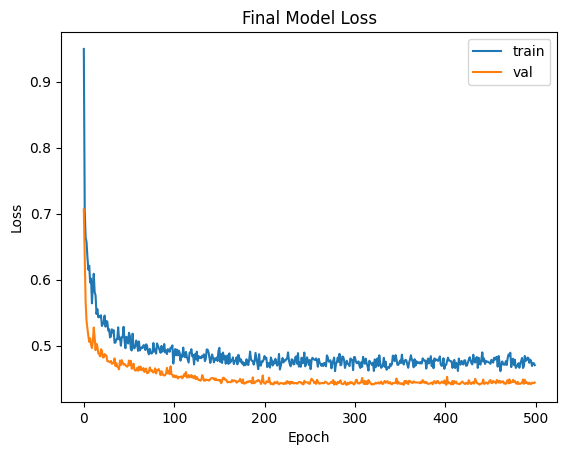

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

=== Metrics SOC_10 final ===
   Site        R2      RMSE    n
1     1  0.663004  0.690311  418
0     0  0.524126  0.808536  619
2     2  0.492765  0.790614  762
Final SOC_10 -> R2: 0.569 | RMSE: 0.775


['final_model_soc10.pkl']

In [173]:
#  Entraînement final  sur TOUT le jeu


def fit_full_models(df_in, features, artifact, hidden=[256,128,64], dropout=0.25, cfg=TrainCfg()):
    X = df_in[features].values
    y = df_in[artifact["target"]].values.astype(float)
    tt = artifact["transformer"]
    y_t = tt.transform(y)

    imp = SimpleImputer(strategy="median").fit(X)
    sc  = StandardScaler().fit(imp.transform(X))
    Xs  = sc.transform(imp.transform(X))
    tracker = LossTracker()
    model, _, _ = train_one_fold(Xs, y_t, Xs, y_t, None, None, hidden=hidden, dropout=dropout, cfg=cfg, tracker=tracker)
    
    
    
    
    plot_losses(tracker, title="Final Model Loss")
    return {"model": model, "imputer": imp, "scaler": sc, "transformer": tt, "features": features}

# For SOC_10 final training
final10 = fit_full_models(
    df, FEATURES, art10,
    cfg=TrainCfg(epochs=500, patience=1000)  # Disable early stopping
)
df_with_soc10pred_train = df.copy()
df_with_soc10pred_train["SOC10_pred"] = predict_nn_ensemble(
    {"models":[final10["model"]], "imputers":[final10["imputer"]], "scalers":[final10["scaler"]],
     "transformer": final10["transformer"], "features": final10["features"]},
    df_with_soc10pred_train
)

 # ==============================================================
# affichage des métriques finales   
# ==============================================================
metrics10 = per_site_metrics(
    df_with_soc10pred_train[TARGET_10], df_with_soc10pred_train["SOC10_pred"], df_with_soc10pred_train[GROUP_COL]
)
print(f"\n=== Metrics SOC_10 final ===")
print(metrics10)

# print r2 and rmse for SOC_10
r2_10 = r2_score(df_with_soc10pred_train[TARGET_10], df_with_soc10pred_train["SOC10_pred"])
rmse_10 = np.sqrt(mean_squared_error(df_with_soc10pred_train[TARGET_10], df_with_soc10pred_train["SOC10_pred"]))
print(f"Final SOC_10 -> R2: {r2_10:.3f} | RMSE: {rmse_10:.3f}")



# save model



joblib.dump(final10, "final_model_soc10.pkl")


In [174]:
df_with_soc10pred_villages = data_train.copy()
df_with_soc10pred_villages["SOC10_pred"] = predict_nn_ensemble(
    {"models":[final10["model"]], "imputers":[final10["imputer"]], "scalers":[final10["scaler"]],
     "transformer": final10["transformer"], "features": final10["features"]},
    df_with_soc10pred_villages
)
df_with_soc10pred_villages

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']


,ProfileID,Longitude_x,Latitude_x,T_Year_x,Start_Date_x,End_Date_x,Satellite_x,SR_B1,SR_B2,SR_B3,...,B9,B11,B12,SNDVI,SGDVI,SMSAVI2,SPSRINIR,SNDWI,Scigreen,SOC10_pred
0,2.0,-16.549937,14.534548,2020.0,2020-01-01,2020-12-31,Landsat-8,10613.400000,11463.400000,14057.800000,...,3829.500000,5691.009434,5236.330189,0.177614,0.329348,0.301623,1.251518,-0.329348,0.161162,3.265612
1,8.0,-16.550234,14.547790,2020.0,2020-01-01,2020-12-31,Landsat-8,10178.580952,11101.114286,13465.619048,...,3974.000000,5471.915094,4550.679245,0.186775,0.337739,0.314732,1.254775,-0.337739,0.161128,3.751521
2,3.0,-16.549982,14.536586,2020.0,2020-01-01,2020-12-31,Landsat-8,10460.047619,11248.952381,13746.857143,...,3702.895238,5507.942857,5137.866667,0.175287,0.326190,0.298258,1.262451,-0.326190,0.160054,3.149001
3,7.0,-16.550183,14.545536,2020.0,2020-01-01,2020-12-31,Landsat-8,10466.400000,11366.800000,13827.600000,...,4095.000000,5736.895238,5042.104762,0.183727,0.335066,0.310394,1.270795,-0.335066,0.161266,3.268555
4,4.0,-16.550032,14.538797,2020.0,2020-01-01,2020-12-31,Landsat-8,9855.512821,10629.871795,12886.487179,...,3579.844828,4857.827586,4323.896552,0.223521,0.362161,0.365338,1.358693,-0.362161,0.150851,4.728329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3018,3019.0,-16.428301,14.485332,2020.0,2020-01-01,2020-12-31,Landsat-8,10276.038095,11093.619048,13469.514286,...,3877.201923,5211.826923,4484.673077,0.205806,0.351794,0.341327,1.320882,-0.351794,0.157383,3.897629
3019,3020.0,-16.428304,14.487493,2020.0,2020-01-01,2020-12-31,Landsat-8,10382.809524,11190.095238,13404.952381,...,3957.828571,5215.314286,4503.600000,0.193468,0.338858,0.324182,1.281633,-0.338858,0.155590,3.728455
3020,3021.0,-16.428478,14.489698,2020.0,2020-01-01,2020-12-31,Landsat-8,10244.266667,11057.647619,13444.400000,...,3996.423077,5476.115385,4539.884615,0.186400,0.339049,0.314199,1.265335,-0.339049,0.162948,3.625729
3021,3022.0,-16.428710,14.491891,2020.0,2020-01-01,2020-12-31,Landsat-8,10342.495238,11220.095238,13877.352381,...,4515.000000,5365.000000,4265.000000,0.215260,0.361947,0.354235,1.343172,-0.361947,0.159081,3.455526


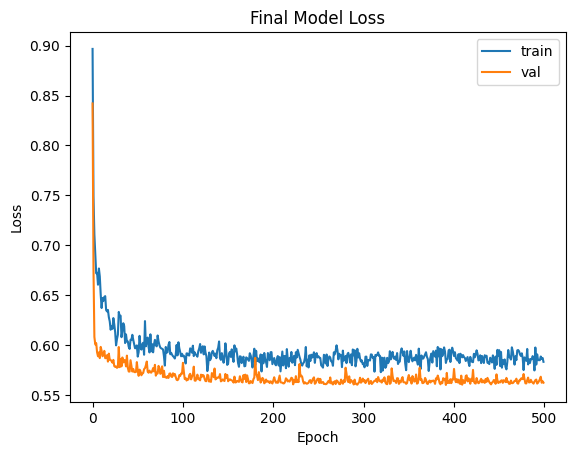

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SOC10_pred']

=== Metrics SOC_30 final ===
   Site        R2      RMSE    n
1     1  0.550337  0.741095  415
0     0  0.441927  0.883913  619
2     2  0.365917  0.772830  762
Final SOC_30 -> R2: 0.475 | RMSE: 0.806


['final_model_soc30.pkl']

In [175]:

FEATURES_30 = FEATURES + ["SOC10_pred"]
FEATURES_30 = [c for c in FEATURES_30 if c in df_with_soc10pred_train.columns]

# Drop rows with NaN in SOC_30 for final training
df_soc30_train = df_with_soc10pred_train.dropna(subset=[TARGET_30])

# For SOC_30 final training
final30 = fit_full_models(
    df_soc30_train, FEATURES_30, art30,
    cfg=TrainCfg(epochs=500, patience=1000)  # Disable early stopping
)

df_with_soc30pred = df_with_soc10pred_train.copy()
df_with_soc30pred["SOC30_pred"] = predict_nn_ensemble(
    {"models":[final30["model"]], "imputers":[final30["imputer"]], "scalers":[final30["scaler"]],
     "transformer": final30["transformer"], "features": final30["features"]},
    df_with_soc30pred
)

# Filter out rows with NaN in SOC_30 or SOC30_pred before computing metrics
mask = (~df_with_soc30pred["SOC_30"].isna()) & (~df_with_soc30pred["SOC30_pred"].isna())
metrics30 = per_site_metrics(
    df_with_soc30pred.loc[mask, TARGET_30], df_with_soc30pred.loc[mask, "SOC30_pred"], df_with_soc30pred.loc[mask, GROUP_COL]
)
print(f"\n=== Metrics SOC_30 final ===")
print(metrics30)

r2_30 = r2_score(df_with_soc30pred.loc[mask, TARGET_30], df_with_soc30pred.loc[mask, "SOC30_pred"])
rmse_30 = np.sqrt(mean_squared_error(df_with_soc30pred.loc[mask, TARGET_30], df_with_soc30pred.loc[mask, "SOC30_pred"]))
print(f"Final SOC_30 -> R2: {r2_30:.3f} | RMSE: {rmse_30:.3f}")
joblib.dump(final30, "final_model_soc30.pkl")

In [181]:
### lire le model et faire des prédictions sur de nouvelles données
#load model




final10 = joblib.load("final_model_soc10.pkl")
final30 = joblib.load("final_model_soc30.pkl")

data_new = pd.read_csv("zones_villages.csv")

df = data_new.copy()

# filter features that are not in data_new
# Use the features stored in the model artifacts for prediction
data_new["SOC10_pred"] = predict_nn_ensemble(
    {"models":[final10["model"]], "imputers":[final10["imputer"]], "scalers":[final10["scaler"]],
     "transformer": final10["transformer"], "features": final10["features"]},
    data_new
)
data_new["SOC30_pred"] = predict_nn_ensemble(
    {"models":[final30["model"]], "imputers":[final30["imputer"]], "scalers":[final30["scaler"]],
     "transformer": final30["transformer"], "features": final30["features"]},
    data_new
)

""" data_new["SOC10_pred"] = data_new["SOC10_pred"].clip(lower=0)
data_new["SOC30_pred"] = data_new["SOC30_pred"].clip(lower=0) """


print(data_new[["SOC10_pred","SOC30_pred"]].head())

# data_new["SOC10_pred"] = np.expm1(data_new["SOC10_pred"])
# print(data_new["SOC10_pred"].head())
data_new.to_csv("data_test_sentinel_landsat_with_predictions.csv", index=False)

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SOC10_pred']
   SOC10_pred  SOC30_pred
0    3.265612    2.529916
1    3.751521    2.872751
2    3.149001    2.768339
3    3.268555    2.462017
4    4.728329    3.225158


In [182]:
import os
import joblib
import pandas as pd
import numpy as np

# ---------- Utils ----------
def check_file(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Fichier introuvable: {path}")

def prepare_for_model(artifact: dict, df: pd.DataFrame) -> pd.DataFrame:
    """
    - Vérifie les features attendues
    - Ajoute les colonnes manquantes (remplies avec NaN)
    - Trie l'ordre des colonnes comme à l'entraînement
    - Force en float (utile pour scaler/imputer)
    """
    feat = artifact.get("features", [])
    if not feat:
        raise ValueError("L'artefact ne contient pas la clé 'features' ou elle est vide.")

    # Colonnes manquantes
    missing = [c for c in feat if c not in df.columns]
    if missing:
        # On les ajoute avec NaN; si votre pipeline a un imputer, il s'en chargera
        for c in missing:
            df[c] = np.nan
        print(f"[WARN] Colonnes manquantes ajoutées (remplies NaN): {missing}")

    # Colonnes en trop (informationnel)
    extra = [c for c in df.columns if c not in feat]
    if extra:
        print(f"[INFO] Colonnes ignorées (non utilisées par le modèle): {extra}")

    X = df[feat].copy()

    # Forcer en float si possible (évite les soucis avec StandardScaler/Imputer)
    for c in X.columns:
        if not np.issubdtype(X[c].dtype, np.number):
            X[c] = pd.to_numeric(X[c], errors="coerce")

    return X

def predict_with_artifact(artifact: dict, df: pd.DataFrame, pred_col: str) -> pd.Series:
    """
    Prépare X selon 'features' puis appelle predict_nn_ensemble(artifact, df_prepared)
    On laisse votre fonction gérer imputer/scaler/transformer internes.
    """
    X = prepare_for_model(artifact, df.copy())
    # On passe un dataframe contenant au moins les colonnes requises
    # Si votre predict_nn_ensemble attend l'ensemble du df, on merge X dans df :
    tmp = df.copy()
    for c in X.columns:
        tmp[c] = X[c]
    yhat = predict_nn_ensemble(
        {
            "models": [artifact["model"]],
            "imputers": [artifact.get("imputer")],
            "scalers": [artifact.get("scaler")],
            "transformer": artifact.get("transformer"),
            "features": artifact["features"],
        },
        tmp
    )
    return pd.Series(yhat, index=df.index, name=pred_col)

# ---------- Main ----------
check_file("final_model_soc10.pkl")
check_file("final_model_soc30.pkl")
check_file("zones_villages.csv")

final10 = joblib.load("final_model_soc10.pkl")
final30 = joblib.load("final_model_soc30.pkl")

data_new = pd.read_csv("zones_villages.csv")
df = data_new.copy()

# Prédictions robustes
df["SOC10_pred"] = predict_with_artifact(final10, df, "SOC10_pred")
df["SOC30_pred"] = predict_with_artifact(final30, df, "SOC30_pred")






# Sauvegarde
out_path = "data_test_sentinel_landsat_with_predictions.csv"
df.to_csv(out_path, index=False)
print(f"[OK] Fichier écrit: {out_path}")
df[["SOC10_pred","SOC30_pred"]].head()



[INFO] Colonnes ignorées (non utilisées par le modèle): ['ProfileID', 'Longitude_x', 'Latitude_x', 'T_Year_x', 'Start_Date_x', 'End_Date_x', 'Satellite_x', 'QA_PIXEL', 'LNDVI', 'LNDWI', 'LBSI', 'Lcigreen', 'Longitude_y', 'Latitude_y', 'T_Year_y', 'Start_Date_y', 'End_Date_y', 'Satellite_y', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'SNDVI', 'SGDVI', 'SMSAVI2', 'SPSRINIR', 'SNDWI', 'Scigreen']
['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
[INFO] Colonnes ignorées (non utilisées par le modèle): ['ProfileID', 'Longitude_x', 'Latitude_x', 'T_Year_x', 'Start_Date_x', 'End_Date_x', 'Satellite_x', 'QA_PIXEL', 'LNDVI', 'LNDWI', 'LBSI', 'Lcigreen', 'Longitude_y', 'Latitude_y', 'T_Year_y', 'Start_Date_y', 'End_Date_y', 'Satellite_y', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'SNDVI', 'SGDVI', 'SMSAVI2', 'SPSRINIR', 'SNDWI', 'Scigreen']
['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SOC10_pred']


,SOC10_pred,SOC30_pred
0,3.265612,2.529916
1,3.751521,2.872751
2,3.149001,2.768339
3,3.268555,2.462017
4,4.728329,3.225158


In [183]:
import matplotlib.pyplot as plt

# ---- utilitaires ----
def enable_dropout_only(model: nn.Module):
    """
    Met tout le modèle en eval(), puis réactive uniquement les Dropout en train().
    Laisse BatchNorm en eval (important pour stabilité des stats).
    """
    model.eval()
    for m in model.modules():
        if isinstance(m, nn.Dropout) or isinstance(m, nn.Dropout1d) or isinstance(m, nn.Dropout2d):
            m.train()

def mc_dropout_predict(model: nn.Module, X: np.ndarray, T: int = 50, batch_size: int = 8192,
                       device: str = "cpu", preprocess=None):
    """
    MC Dropout pour données tabulaires.
    X: (H, W, D) ou (N, D), numpy.float32
    Retourne: mean (N,), std (N,), q05 (N,), q95 (N,)
    """
    assert X.ndim in (2, 3), "X doit être (N, D) ou (H, W, D)"
    H = W = None
    if X.ndim == 3:
        H, W, D = X.shape
        Xf = X.reshape(-1, D)
    else:
        Xf = X
        D = Xf.shape[1]

    if preprocess is not None:
        Xf = preprocess(Xf)

    xb = torch.from_numpy(Xf.astype(np.float32))
    device = torch.device(device)
    xb = xb.to(device)

    # Activer uniquement Dropout
    enable_dropout_only(model)
    model.to(device)
    model.requires_grad_(False)

    preds_T = []
    with torch.no_grad():
        for _ in range(T):
            # itérer en batch pour éviter OOM
            out_list = []
            for i in range(0, xb.shape[0], batch_size):
                out = model(xb[i:i+batch_size])  # [B,1] ou [B]
                out = out.squeeze(-1)
                out_list.append(out)
            yhat = torch.cat(out_list, dim=0).detach().cpu().numpy()  # [N]
            preds_T.append(yhat)

    P = np.stack(preds_T, axis=0)  # [T, N]
    mu  = P.mean(axis=0)
    std = P.std(axis=0, ddof=1)
    q05 = np.quantile(P, 0.05, axis=0)
    q95 = np.quantile(P, 0.95, axis=0)

    if X.ndim == 3:
        mu  = mu.reshape(H, W)
        std = std.reshape(H, W)
        q05 = q05.reshape(H, W)
        q95 = q95.reshape(H, W)

    return mu, std, q05, q95

def plot_uncertainty(mu, std, q05, q95, titles_suffix=""):
    """
    Affiche 3 cartes : moyenne, écart-type, largeur IC 90%.
    Accepte matrices 2D (H,W) ; si vecteurs 1D, fait des histos.
    """
    if mu.ndim == 2:
        H, W = mu.shape
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        im0 = axs[0].imshow(mu, cmap="viridis"); axs[0].set_title(f"Prédiction (µ){titles_suffix}"); plt.colorbar(im0, ax=axs[0], fraction=0.046)
        im1 = axs[1].imshow(std, cmap="magma"); axs[1].set_title(f"Incertitude (σ){titles_suffix}"); plt.colorbar(im1, ax=axs[1], fraction=0.046)
        im2 = axs[2].imshow(q95 - q05, cmap="plasma"); axs[2].set_title(f"Largeur IC 90% (q95−q05){titles_suffix}"); plt.colorbar(im2, ax=axs[2], fraction=0.046)
        for ax in axs: ax.set_xticks([]); ax.set_yticks([])
        plt.tight_layout(); plt.show()
    else:
        # fallback 1D : histos
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        axs[0].hist(mu, bins=50); axs[0].set_title(f"µ{titles_suffix}")
        axs[1].hist(std, bins=50); axs[1].set_title(f"σ{titles_suffix}")
        axs[2].hist((q95-q05), bins=50); axs[2].set_title(f"IC90 largeur{titles_suffix}")
        plt.tight_layout(); plt.show()




[INFO] Colonnes ignorées (non utilisées par le modèle): ['ProfileID', 'Longitude_x', 'Latitude_x', 'T_Year_x', 'Start_Date_x', 'End_Date_x', 'Satellite_x', 'QA_PIXEL', 'LNDVI', 'LNDWI', 'LBSI', 'Lcigreen', 'Longitude_y', 'Latitude_y', 'T_Year_y', 'Start_Date_y', 'End_Date_y', 'Satellite_y', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'SNDVI', 'SGDVI', 'SMSAVI2', 'SPSRINIR', 'SNDWI', 'Scigreen', 'SOC10_pred', 'SOC30_pred']


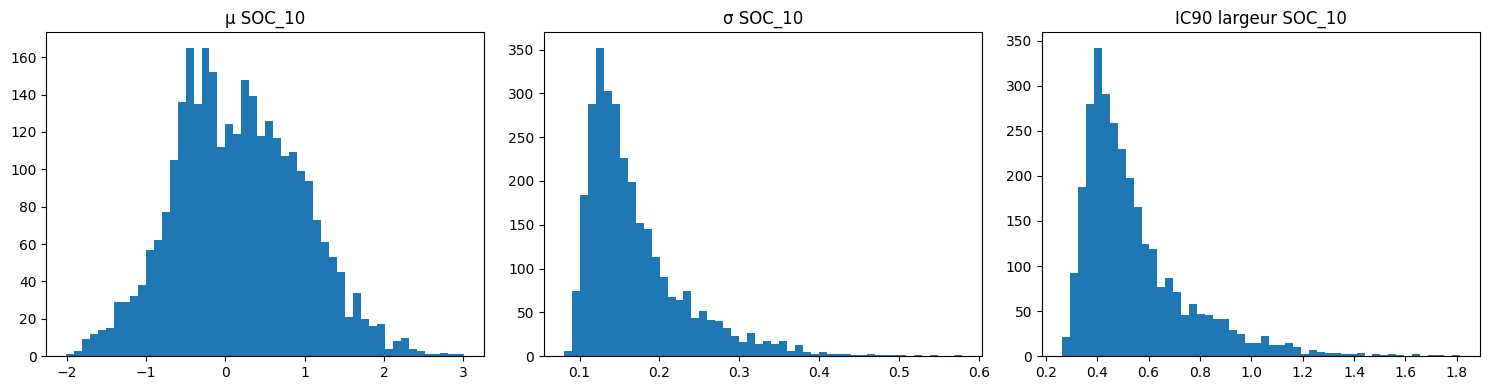

In [184]:

from joblib import load
def preprocess_fn(model, Xf): 
    return model["scaler"].transform(model["imputer"].transform(Xf))
# Load SOC_10 model and predict SOC10_pred
soc10_model = load("final_model_soc10.pkl")

X_10 = prepare_for_model(soc10_model, df.copy()).values
mu_10, std_10, q05_10, q95_10 = mc_dropout_predict(
    soc10_model["model"], X_10, T=100, batch_size=8192,
    device=device, preprocess=lambda Xf: preprocess_fn(soc10_model, Xf)
)
plot_uncertainty(mu_10, std_10, q05_10, q95_10, titles_suffix=" SOC_10")

['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']


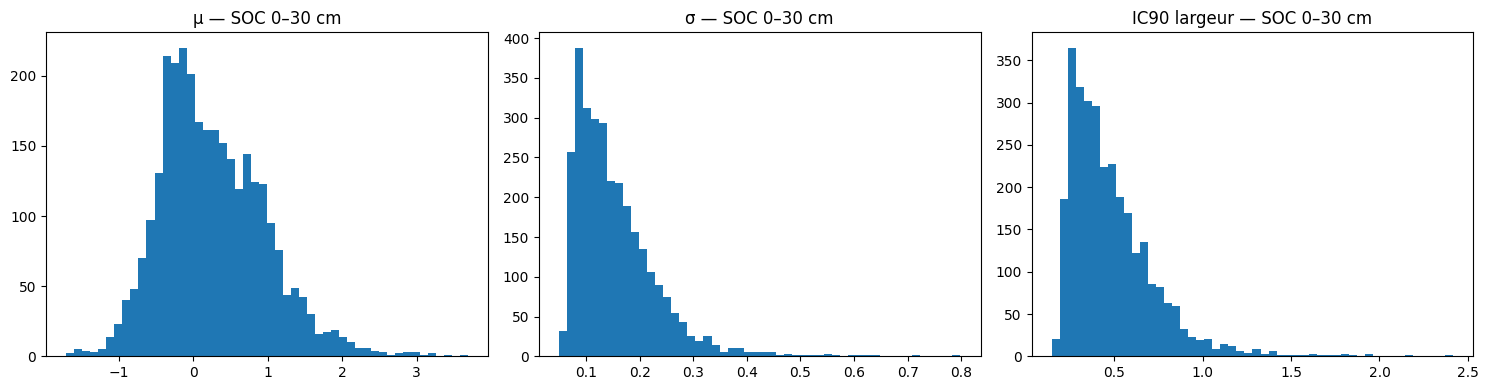

In [185]:
df["SOC10_pred"] = predict_nn_ensemble(
    {"models": [soc10_model["model"]],
     "imputers": [soc10_model["imputer"]],
     "scalers": [soc10_model["scaler"]],
     "transformer": soc10_model["transformer"],
     "features": soc10_model["features"]},
    df
)
# Now load SOC_30 model and predict uncertainty
model = load("final_model_soc30.pkl")  

X = df[model["features"]].values.astype(np.float32)

mu, std, q05, q95 = mc_dropout_predict(model["model"], X, T=50, device="cpu", preprocess=lambda Xf: preprocess_fn(model, Xf))

plot_uncertainty(mu, std, q05, q95, titles_suffix=" — SOC 0–30 cm")